In [1]:
# Import packages

import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Quantization

For the quantization we used **Float16 Quantization**. So, we can take the advantages of float16 quantization are as follows:

- It reduces model size by up to half (since all weights become half of their original size).
- It causes minimal loss in accuracy.
- It supports some delegates (e.g. the GPU delegate) which can operate directly on float16 data, resulting in faster execution than float32 computations.

The disadvantages of float16 quantization are as follows:

- It does not reduce latency as much as a quantization to fixed point math.
- By default, a float16 quantized model will "dequantize" the weights values to float32 when run on the CPU. (Note that the GPU delegate - - will not perform this dequantization, since it can operate on float16 data.)

Source: [https://www.tensorflow.org/lite/performance/post_training_quantization](https://www.tensorflow.org/lite/performance/post_training_quantization)

In [3]:
converter = tf.lite.TFLiteConverter.from_saved_model('../saved_models/1654016648/')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Convert to Tensorflow Lite Format

In [4]:
tflite_model_file = pathlib.Path('./ypc.tflite')
tflite_model_file.write_bytes(tflite_model)

48006336

# Try it Out

In [5]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [7]:
img = tf.keras.preprocessing.image.load_img('../sample_images/test1.jpg', target_size=(224, 224)) # Change the img path to your own
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)

interpreter.set_tensor(input_index, x)
interpreter.invoke()
predicted = interpreter.get_tensor(output_index)

In [8]:
classes = [
    'Abyssinian',
    'american_bulldog',
    'american_pit_bull_terrier',
    'basset_hound',
    'beagle',
    'Bengal',
    'Birman',
    'Bombay',
    'boxer',
    'British_Shorthair',
    'chihuahua',
    'Egyptian_Mau',
    'english_cocker_spaniel',
    'english_setter',
    'german_shorthaired',
    'great_pyrenees',
    'havanese',
    'japanese_chin',
    'keeshond',
    'leonberger',
    'Maine_Coon',
    'miniature_pinscher',
    'newfoundland',
    'Persian',
    'pomeranian',
    'pug',
    'Ragdoll',
    'Russian_Blue',
    'saint_bernard',
    'samoyed',
    'scottish_terrier',
    'shiba_inu',
    'Siamese',
    'Sphynx',
    'staffordshire_bull_terrier',
    'wheaten_terrier',
    'yorkshire_terrier']

classes = sorted(classes)
print('Num classes:', len(classes))

Num classes: 37


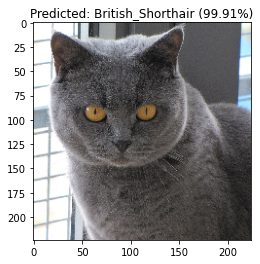

In [9]:
class_predicted = classes[np.argmax(predicted)]
confidence = predicted[0][np.argmax(predicted)] * 100

plt.imshow(img)
plt.title('Predicted: {} ({:.2f}%)'.format(class_predicted, confidence))
plt.show()